In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import sampler
from torch.utils.data import DataLoader

import torchvision.datasets as dset
import torchvision.transforms as T

import timeit

import models
import solver
import views
import model_net_arch
import torchsummary.torchsummary

In [3]:
dtype = torch.FloatTensor
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor

print_every = 100

def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
    
    
def show_solver_training(solver):
    views.show_traning(solver.loss_history, solver.train_acc_history, solver.val_acc_history)

    
def show_mean_and_std_hist(parameters):
    paras = [w.data.cpu().numpy() for w in parameters]
    views.plot_mean_std_hist(paras)

    
def show_conv_layer_weights(conv_weights):
    conv_weights = conv_weights.data.cpu().numpy()
    conv_weights = conv_weights.transpose(0, 2, 3, 1)
    views.show_conv_weights(conv_weights)

    
def compare_solvers_tranings(solvers_with_labels):
    loss_train_val_acc_with_labels = {}
    for label, solver in solvers_with_labels.items():
        loss_train_val_acc_with_labels[label] = (solver.loss_history, solver.train_acc_history, solver.val_acc_history)
    
    views.compare_trainings(loss_train_val_acc_with_labels)

def compare_training_stats(train_stats):
    loss_train_val_acc_with_labels = { }
    
    for (lr, reg) in train_stats:
        train_acc, val_acc, loss_history = train_stats[(lr, reg)]
        loss_train_val_acc_with_labels[str(lr) + ' ' + str(reg)] = (loss_history, train_acc, val_acc)
    
    views.compare_trainings(loss_train_val_acc_with_labels)


In [4]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset.
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from"""
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start
        
    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))
    
    def __len__(self):
        return self.num_samples
    
NUM_TRAIN = 49000
NUM_VAL = 1000

NUM_TRAIN_SMALL = 64

cifar10_train_small = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train_small = DataLoader(cifar10_train_small, batch_size=64, sampler=ChunkSampler(NUM_TRAIN_SMALL, 0))

cifar10_train = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))

cifar10_val = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
# cifar10_val = cifar10_train # can do this?
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('../cs231n/datasets/', train=False, download=True, transform=T.ToTensor())
loader_test = DataLoader(cifar10_test, batch_size=64)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
torch.cuda.random.manual_seed(12345)

train_stats = { }

model_feature_type = 'A1'
model_classifier_type = 'base'
use_batch_norm = True

sf_model = model_net_arch.DepthNet(model_feature_type, model_classifier_type, use_batch_norm).type(dtype)
sf_loss_fn = nn.CrossEntropyLoss().type(dtype)

max_count = 1

for i in range(max_count):
    lr = 10**np.random.uniform(-5, -1)
    reg = 10**np.random.uniform(-6, -1)

    lr = 1e-3
    reg = 1e-2
    
    num_epochs = 25

    step_size = 10
    gamma = 0.2
    verbose = True
    
    sf_model.apply(reset)

    sf_optimizer = optim.SGD(sf_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
    sf_lr_scheduler = lr_scheduler.StepLR(sf_optimizer, step_size=step_size, gamma=gamma)
    #sf_lr_scheduler = None
    
    sf_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                          model=sf_model,
                                          loss_fn=sf_loss_fn,
                                          optimizer=sf_optimizer,
                                          scheduler=sf_lr_scheduler,
                                          dtype=dtype,
                                          num_epochs=num_epochs,
                                          verbose=verbose
                                         )

    sf_solver.train()
    
    train_stats[(lr, reg)] = (sf_solver.train_acc_history, sf_solver.val_acc_history, sf_solver.loss_history)
    print('val accuracy: %f, train accuracy: %f, final loss: %f, lr: %e, reg: %e' % (
        sf_solver.val_acc_history[-1], sf_solver.train_acc_history[-1], sf_solver.loss_history[-1], lr, reg))

t = 0, loss = 2.3103
t = 100, loss = 1.9641
t = 200, loss = 1.5815
t = 300, loss = 1.6909
t = 400, loss = 1.5589
t = 500, loss = 1.5542
t = 600, loss = 1.4262
t = 700, loss = 1.4114
(Epoch 0 / 25) train acc: 0.481445; val acc: 0.490000
t = 0, loss = 1.3657
t = 100, loss = 1.2398
t = 200, loss = 1.0813
t = 300, loss = 1.2218
t = 400, loss = 1.1487
t = 500, loss = 1.3460
t = 600, loss = 1.2213
t = 700, loss = 1.2390
(Epoch 1 / 25) train acc: 0.551758; val acc: 0.562000
t = 0, loss = 1.1548
t = 100, loss = 1.0294
t = 200, loss = 0.9340
t = 300, loss = 1.0816
t = 400, loss = 1.0219
t = 500, loss = 1.2468
t = 600, loss = 1.0752
t = 700, loss = 1.1278
(Epoch 2 / 25) train acc: 0.517578; val acc: 0.505000
t = 0, loss = 0.9832
t = 100, loss = 0.9038
t = 200, loss = 0.8398
t = 300, loss = 1.0105
t = 400, loss = 0.9762
t = 500, loss = 1.1836
t = 600, loss = 0.9859
t = 700, loss = 1.0596
(Epoch 3 / 25) train acc: 0.532227; val acc: 0.506000
t = 0, loss = 0.8988
t = 100, loss = 0.8423
t = 200, los

In [9]:
torchsummary.summary(sf_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
           Flatten-9                 [-1, 4096]               0
           Linear-10                 [-1, 1024]       4,195,328
             ReLU-11                 [-1, 1024]               0
           Linear-12                   [-1, 10]          10,250
BaseClassiferHead-13                   [-1, 10]               0
Total params: 4,225,162
Trainable param

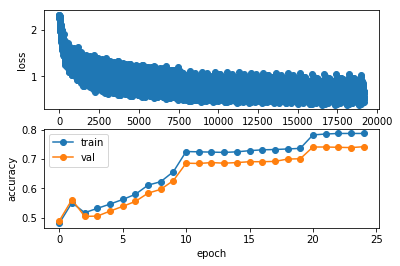

In [10]:
show_solver_training(sf_solver)

In [ ]:
# dropout
torch.cuda.random.manual_seed(12345)

train_stats = { }

model_feature_type = 'B1'
model_classifier_type = 'dropout'
use_batch_norm = True

#sf_model = model_net_arch.DepthNet(model_feature_type, model_classifier_type, use_batch_norm).type(dtype)
sf_model.load_state_dict(sf_solver.get_best_model_wts())
sf_loss_fn = nn.CrossEntropyLoss().type(dtype)

max_count = 1

for i in range(max_count):
    lr = 10**np.random.uniform(-2, -1)
    reg = 10**np.random.uniform(-5, -1)

    lr = 4.009636e-02 * 0.1
    reg = 1.508593e-05
    
    num_epochs = 100

    step_size = 10
    gamma = 0.2
    verbose = True
    
    #sf_model.apply(reset)

    sf_optimizer = optim.SGD(sf_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
    sf_lr_scheduler = lr_scheduler.StepLR(sf_optimizer, step_size=step_size, gamma=gamma)
    sf_lr_scheduler = None
    
    sf_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                          model=sf_model,
                                          loss_fn=sf_loss_fn,
                                          optimizer=sf_optimizer,
                                          scheduler=sf_lr_scheduler,
                                          dtype=dtype,
                                          num_epochs=num_epochs,
                                          verbose=verbose
                                         )

    sf_solver.train()
    
    train_stats[(lr, reg)] = (sf_solver.train_acc_history, sf_solver.val_acc_history, sf_solver.loss_history)
    print('val accuracy: %f, train accuracy: %f, final loss: %f, lr: %e, reg: %e' % (
        sf_solver.val_acc_history[-1], sf_solver.train_acc_history[-1], sf_solver.loss_history[-1], lr, reg))

t = 0, loss = 0.3119
t = 100, loss = 0.2811
t = 200, loss = 0.2519
t = 300, loss = 0.1986
t = 400, loss = 0.1642
t = 500, loss = 0.2848
t = 600, loss = 0.0868
t = 700, loss = 0.1897
(Epoch 0 / 100) train acc: 0.908203; val acc: 0.821000
t = 0, loss = 0.2127
t = 100, loss = 0.4847
t = 200, loss = 0.2075
t = 300, loss = 0.2274
t = 400, loss = 0.2222
t = 500, loss = 0.5291
t = 600, loss = 0.2175
t = 700, loss = 0.3264
(Epoch 1 / 100) train acc: 0.928711; val acc: 0.826000
t = 0, loss = 0.1819
t = 100, loss = 0.4268
t = 200, loss = 0.1852
t = 300, loss = 0.2410
t = 400, loss = 0.1578
t = 500, loss = 0.3006
t = 600, loss = 0.1172
t = 700, loss = 0.2638
(Epoch 2 / 100) train acc: 0.934570; val acc: 0.820000
t = 0, loss = 0.1115
t = 100, loss = 0.2499
t = 200, loss = 0.1124
t = 300, loss = 0.1038
t = 400, loss = 0.1376
t = 500, loss = 0.1685
t = 600, loss = 0.0454
t = 700, loss = 0.1528
(Epoch 3 / 100) train acc: 0.950195; val acc: 0.827000
t = 0, loss = 0.2465
t = 100, loss = 0.3687
t = 200,

val accuracy: 0.791000, train accuracy: 0.853516, final loss: 0.442047, lr: 4.009636e-02, reg: 1.508593e-05
val accuracy: 0.763000, train accuracy: 0.820312, final loss: 0.231458, lr: 9.462230e-03, reg: 1.862956e-05
val accuracy: 0.743000, train accuracy: 0.799805, final loss: 0.313343, lr: 3.787566e-02, reg: 3.528884e-04
val accuracy: 0.739000, train accuracy: 0.793945, final loss: 0.233956, lr: 1.385484e-02, reg: 3.810284e-05
val accuracy: 0.721000, train accuracy: 0.754883, final loss: 0.284047, lr: 1.830989e-02, reg: 3.444471e-04
val accuracy: 0.721000, train accuracy: 0.752930, final loss: 0.518981, lr: 4.171765e-02, reg: 6.953063e-04

val accuracy: 0.707000, train accuracy: 0.712891, final loss: 0.722279, lr: 6.588910e-02, reg: 7.679667e-05
val accuracy: 0.656000, train accuracy: 0.676758, final loss: 0.613964, lr: 4.705129e-03, reg: 5.352548e-03
val accuracy: 0.718000, train accuracy: 0.757812, final loss: 0.409217, lr: 7.157260e-03, reg: 2.199067e-05
val accuracy: 0.709000, train accuracy: 0.708008, final loss: 0.610777, lr: 2.245004e-03, reg: 3.378343e-03
val accuracy: 0.673000, train accuracy: 0.694336, final loss: 0.905235, lr: 5.751695e-04, reg: 2.783821e-04
val accuracy: 0.484000, train accuracy: 0.472656, final loss: 1.438882, lr: 9.393207e-02, reg: 2.852527e-03
val accuracy: 0.706000, train accuracy: 0.738281, final loss: 0.484283, lr: 2.362645e-03, reg: 9.035896e-04
val accuracy: 0.679000, train accuracy: 0.716797, final loss: 0.435924, lr: 7.358177e-03, reg: 1.133665e-03
val accuracy: 0.610000, train accuracy: 0.593750, final loss: 1.238668, lr: 2.150678e-04, reg: 7.295178e-04
val accuracy: 0.602000, train accuracy: 0.604492, final loss: 1.357084, lr: 1.858859e-04, reg: 7.936208e-05
val accuracy: 0.539000, train accuracy: 0.541016, final loss: 1.301775, lr: 1.082154e-04, reg: 6.240308e-04
val accuracy: 0.629000, train accuracy: 0.630859, final loss: 1.129231, lr: 2.681573e-04, reg: 2.915249e-04
val accuracy: 0.604000, train accuracy: 0.623047, final loss: 1.278995, lr: 2.103569e-04, reg: 3.462201e-03
val accuracy: 0.529000, train accuracy: 0.531250, final loss: 0.937657, lr: 6.408414e-02, reg: 5.228549e-03

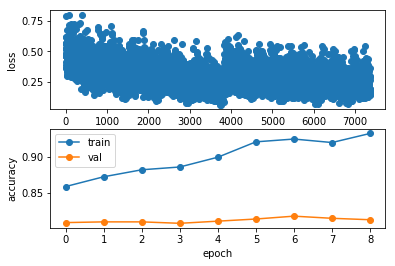

In [76]:
show_solver_training(sf_solver)

In [7]:
# dropout
torch.cuda.random.manual_seed(12345)

train_stats = { }

model_feature_type = 'B2'
model_classifier_type = 'squeeze'
use_batch_norm = True

sf_model = model_net_arch.DepthNet(model_feature_type, model_classifier_type, use_batch_norm).type(dtype)
#sf_model.load_state_dict(sf_solver.get_best_model_wts())
sf_loss_fn = nn.CrossEntropyLoss().type(dtype)

max_count = 1

for i in range(max_count):
    lr = 10**np.random.uniform(-4, -2)
    #lr = 1e-4 * np.random.uniform(5, 10)
    reg = 10**np.random.uniform(-5, -1)

    lr = 7.914013e-04
    reg = 1.318884e-04
    
    num_epochs = 50

    step_size = 10
    gamma = 0.2
    verbose = True
    
    #sf_model.apply(reset)

    #sf_optimizer = optim.SGD(sf_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
    #sf_optimizer = optim.RMSprop(sf_model.parameters(), lr=lr, weight_decay=reg)
    sf_optimizer = optim.Adam(sf_model.parameters(), lr=lr, weight_decay=reg, amsgrad=True)
    sf_lr_scheduler = lr_scheduler.StepLR(sf_optimizer, step_size=step_size, gamma=gamma)
    sf_lr_scheduler = None
    
    sf_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                          model=sf_model,
                                          loss_fn=sf_loss_fn,
                                          optimizer=sf_optimizer,
                                          scheduler=sf_lr_scheduler,
                                          dtype=dtype,
                                          num_epochs=num_epochs,
                                          verbose=verbose
                                         )

    sf_solver.train()
    
    train_stats[(lr, reg)] = (sf_solver.train_acc_history, sf_solver.val_acc_history, sf_solver.loss_history)
    print('val accuracy: %f, train accuracy: %f, final loss: %f, lr: %e, reg: %e' % (
        sf_solver.val_acc_history[-1], sf_solver.train_acc_history[-1], sf_solver.loss_history[-1], lr, reg))

t = 0, loss = 2.3144
t = 100, loss = 1.7494
t = 200, loss = 1.2528
t = 300, loss = 1.2212
t = 400, loss = 1.1772
t = 500, loss = 1.3711
t = 600, loss = 1.1797
t = 700, loss = 1.1014


/home/yalong/yalong/project/cs231n-assignments/assignment2/my2/solver.py:79: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  x_var = Variable(x.type(self.dtype), volatile=True)
/home/yalong/yalong/project/cs231n-assignments/assignment2/my2/solver.py:80: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  y_var = Variable(y.type(self.dtype).long(), volatile=True)


(Epoch 0 / 50) train acc: 0.661133; val acc: 0.644000
t = 0, loss = 1.0007
t = 100, loss = 0.9446
t = 200, loss = 0.7808
t = 300, loss = 0.8495
t = 400, loss = 0.9091
t = 500, loss = 1.0023
t = 600, loss = 0.8719
t = 700, loss = 0.9080
(Epoch 1 / 50) train acc: 0.707031; val acc: 0.676000
t = 0, loss = 0.7544
t = 100, loss = 0.6645
t = 200, loss = 0.6065
t = 300, loss = 0.7459
t = 400, loss = 0.7051
t = 500, loss = 0.8908
t = 600, loss = 0.7442
t = 700, loss = 0.8097
(Epoch 2 / 50) train acc: 0.711914; val acc: 0.691000
t = 0, loss = 0.5934
t = 100, loss = 0.5801
t = 200, loss = 0.4976
t = 300, loss = 0.6309
t = 400, loss = 0.5417
t = 500, loss = 0.8327
t = 600, loss = 0.6093
t = 700, loss = 0.7561
(Epoch 3 / 50) train acc: 0.750977; val acc: 0.726000
t = 0, loss = 0.4247
t = 100, loss = 0.4968
t = 200, loss = 0.4017
t = 300, loss = 0.5870
t = 400, loss = 0.3918
t = 500, loss = 0.8126
t = 600, loss = 0.5177
t = 700, loss = 0.6700
(Epoch 4 / 50) train acc: 0.729492; val acc: 0.681000
t 

t = 400, loss = 0.0362
t = 500, loss = 0.1115
t = 600, loss = 0.0925
t = 700, loss = 0.0395
(Epoch 35 / 50) train acc: 0.986328; val acc: 0.825000
t = 0, loss = 0.0228
t = 100, loss = 0.0877
t = 200, loss = 0.0387
t = 300, loss = 0.0645
t = 400, loss = 0.0628
t = 500, loss = 0.1645
t = 600, loss = 0.0313
t = 700, loss = 0.0124
(Epoch 36 / 50) train acc: 0.991211; val acc: 0.818000
t = 0, loss = 0.0233
t = 100, loss = 0.0212
t = 200, loss = 0.0132
t = 300, loss = 0.0482
t = 400, loss = 0.0297
t = 500, loss = 0.0428
t = 600, loss = 0.0122
t = 700, loss = 0.0241
(Epoch 37 / 50) train acc: 0.988281; val acc: 0.827000
t = 0, loss = 0.0200
t = 100, loss = 0.0768
t = 200, loss = 0.0337
t = 300, loss = 0.0513
t = 400, loss = 0.0265
t = 500, loss = 0.0183
t = 600, loss = 0.0149
t = 700, loss = 0.0712
(Epoch 38 / 50) train acc: 0.979492; val acc: 0.814000
t = 0, loss = 0.0551
t = 100, loss = 0.0552
t = 200, loss = 0.0541
t = 300, loss = 0.0354
t = 400, loss = 0.0131
t = 500, loss = 0.0440
t = 60

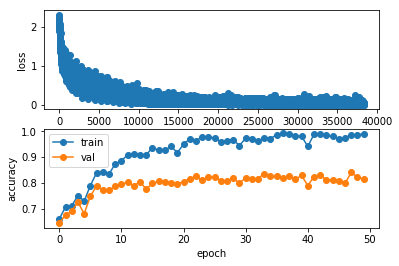

In [8]:
show_solver_training(sf_solver)

In [9]:
show_conv_layer_weights(sf_model.parameters()[0])

TypeError: 'generator' object is not subscriptable